# Stage 09 — Feature Engineering Lecture Notebook

In this notebook, we demonstrate simple but powerful feature engineering transformations on a synthetic financial dataset.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures

# Generate synthetic financial dataset
np.random.seed(42)
n = 200

df = pd.DataFrame({
    'customer_id': range(1, n+1),
    'income': np.random.normal(60000, 15000, n).astype(int),
    'credit_score': np.random.normal(680, 50, n).astype(int),
    'monthly_spend': np.random.normal(2000, 600, n).astype(int),
    'region': np.random.choice(['North','South','East','West'], n),
    'default_flag': np.random.choice([0,1], n, p=[0.8,0.2])
})
df.head()

,customer_id,income,credit_score,monthly_spend,region,default_flag
0,1,67450,697,1043,East,0
1,2,57926,708,1640,West,0
2,3,69715,734,2003,West,0
3,4,82845,732,2028,North,0
4,5,56487,611,1729,South,0


## Basic Transformations

In [3]:
# Percent change in monthly spending
df['spend_pct_change'] = df['monthly_spend'].pct_change().fillna(0)

# Rolling mean of spending (3-month window)
df['rolling_spend_mean'] = df['monthly_spend'].rolling(3).mean().fillna(df['monthly_spend'])

# Binary flag for high spenders
df['high_spender_flag'] = (df['monthly_spend'] > 2500).astype(int)
df.head()

,customer_id,income,credit_score,monthly_spend,region,default_flag,spend_pct_change,rolling_spend_mean,high_spender_flag
0,1,67450,697,1043,East,0,0.000000,1043.000000,0
1,2,57926,708,1640,West,0,0.572387,1640.000000,0
2,3,69715,734,2003,West,0,0.221341,1562.000000,0
3,4,82845,732,2028,North,0,0.012481,1890.333333,0
4,5,56487,611,1729,South,0,-0.147436,1920.000000,0


## Categorical Encoding

In [4]:
# One-hot encoding
df_onehot = pd.get_dummies(df, columns=['region'])

# Label encoding
le = LabelEncoder()
df['region_label'] = le.fit_transform(df['region'])

# Frequency encoding
region_freq = df['region'].value_counts(normalize=True)
df['region_freq'] = df['region'].map(region_freq)
df[['region','region_label','region_freq']].head()

,region,region_label,region_freq
0,East,0,0.275
1,West,3,0.230
2,West,3,0.230
3,North,1,0.240
4,South,2,0.255


## Interaction & Polynomial Features

In [5]:
# Interaction feature
df['income_x_credit'] = df['income'] * df['credit_score']

# Squared feature
df['income_squared'] = df['income'] ** 2

# Polynomial features using sklearn
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[['income','credit_score']])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['income','credit_score']))
df = pd.concat([df, poly_df], axis=1)
df.head()

,customer_id,income,credit_score,monthly_spend,region,default_flag,spend_pct_change,rolling_spend_mean,high_spender_flag,region_label,region_freq,income_x_credit,income_squared,income,credit_score,income^2,income credit_score,credit_score^2
0,1,67450,697,1043,East,0,0.000000,1043.000000,0,0,0.275,47012650,4549502500,67450.0,697.0,4.549502e+09,47012650.0,485809.0
1,2,57926,708,1640,West,0,0.572387,1640.000000,0,3,0.230,41011608,3355421476,57926.0,708.0,3.355421e+09,41011608.0,501264.0
2,3,69715,734,2003,West,0,0.221341,1562.000000,0,3,0.230,51170810,4860181225,69715.0,734.0,4.860181e+09,51170810.0,538756.0
3,4,82845,732,2028,North,0,0.012481,1890.333333,0,1,0.240,60642540,6863294025,82845.0,732.0,6.863294e+09,60642540.0,535824.0
4,5,56487,611,1729,South,0,-0.147436,1920.000000,0,2,0.255,34513557,3190781169,56487.0,611.0,3.190781e+09,34513557.0,373321.0


## Group Walkthrough Implementation

In [6]:
def create_features(df):
    """
    Create engineered features for modeling.
    Assumptions:
    - Rolling mean of spending captures short-term trends.
    - Spend-to-income ratio helps normalize across different income levels.
    """
    # Reset index to avoid duplicate label issues
    df = df.reset_index(drop=True)
    
    df['spend_income_ratio'] = df['monthly_spend'] / df['income']
    df['rolling_spend_mean'] = df['monthly_spend'].rolling(3).mean().fillna(df['monthly_spend'])
    return df

df = create_features(df)
df.head()

ValueError: cannot reindex on an axis with duplicate labels

## Feature Engineering Additional Examples
Feature engineering can be roughly categorized into 10 types:

1. **Combining columns to make a feature** – create new features by combining existing ones.
2. **Splitting a column into multiple features** – extract meaningful components from a single feature.
3. **Transforming features point by point** – apply math or functions to each value individually.
4. **Transforming features by window** – rolling averages, cumulative sums, or other window-based transforms.
5. **Splitting continuous features into categories** – bin numeric features into discrete bins.
6. **Aggregating features across groups** – compute group-level statistics like mean, median, etc.
7. **Interactions between features** – multiply, divide, or create polynomial combinations of features.
8. **Temporal or sequential features** – time since events, day-of-week, seasonal indicators, or differences.
9. **Encoding external knowledge** – map raw features to domain-specific insights (e.g., zip→region, text→sentiment).
10. **Feature selection / reduction** – reduce dimensionality or remove uninformative features (e.g., PCA, factor analysis).

In [13]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Synthetic dataset
np.random.seed(42)
n = 20
df = pd.DataFrame({
    'column0': np.random.randint(1, 10, size=n),
    'column1': np.random.randint(10, 50, size=n)
})

# 1. Combining columns
df['sum_col'] = df['column0'] + df['column1']

# 2. Splitting a column (simulate time split)
df['column1_div_10'] = df['column1'] // 10
df['column1_mod_10'] = df['column1'] % 10

# 3. Transforming point by point
df['log_col1'] = np.log1p(df['column1'])

# 4. Transforming by window
df['rolling_col1'] = df['column1'].rolling(3, min_periods=1).mean()

# 5. Splitting continuous into categories
df['col1_bin'] = pd.cut(df['column1'], bins=[10,20,30,40,50], labels=False)

# 6. Aggregating across groups (using binned column)
df['col1_bin_mean'] = df.groupby('col1_bin')['column1'].transform('mean')

# 7. Interactions
df['interaction'] = df['column0'] * df['column1']

# 8. Temporal/sequential (simulated as index differences)
df['diff_col1'] = df['column1'].diff().fillna(0)

# 9. Encoding external knowledge (simulated mapping)
mapping = {0:'A', 1:'B', 2:'C', 3:'D'}
df['col1_category'] = df['col1_bin'].map(mapping)

# 10. Feature reduction (PCA on column0 and column1)
pca = PCA(n_components=1)
df['pca_component'] = pca.fit_transform(df[['column0','column1']])

df

,column0,column1,sum_col,column1_div_10,column1_mod_10,log_col1,rolling_col1,col1_bin,col1_bin_mean,interaction,diff_col1,col1_category,pca_component
0,7,42,49,4,2,3.761200,42.000000,3,45.333333,294,0.0,D,13.554169
1,4,21,25,2,1,3.091042,31.500000,1,25.000000,84,-21.0,B,-7.565948
2,8,31,39,3,1,3.465736,31.333333,2,34.500000,248,10.0,C,2.615096
3,5,34,39,3,4,3.555348,28.666667,2,34.500000,170,3.0,C,5.467128
4,7,36,43,3,6,3.610918,33.666667,2,34.500000,252,2.0,C,7.561132
5,3,37,40,3,7,3.637586,35.666667,2,34.500000,111,1.0,C,8.367322
6,7,25,32,2,5,3.258097,32.666667,1,25.000000,175,-12.0,B,-3.426103
7,8,24,32,2,4,3.218876,28.666667,1,25.000000,192,-1.0,B,-4.376781
8,5,12,17,1,2,2.564949,20.333333,0,15.400000,60,-12.0,A,-16.507341
9,4,46,50,4,6,3.850148,27.333333,3,45.333333,184,34.0,D,17.405040


## Rolling Average Comparison Demo (Live Demo Friendly)

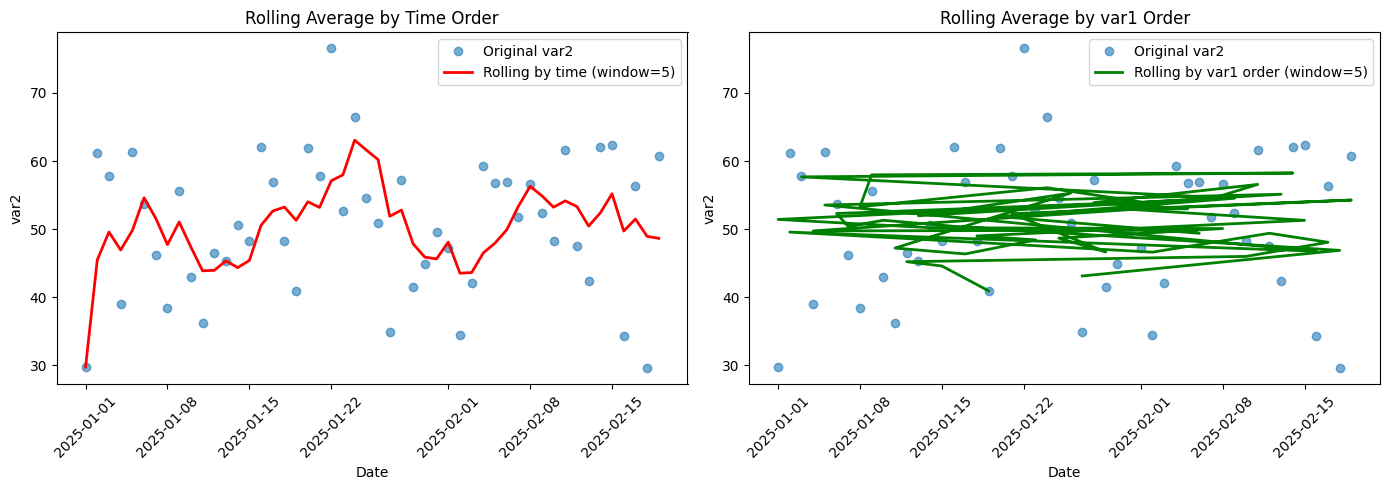

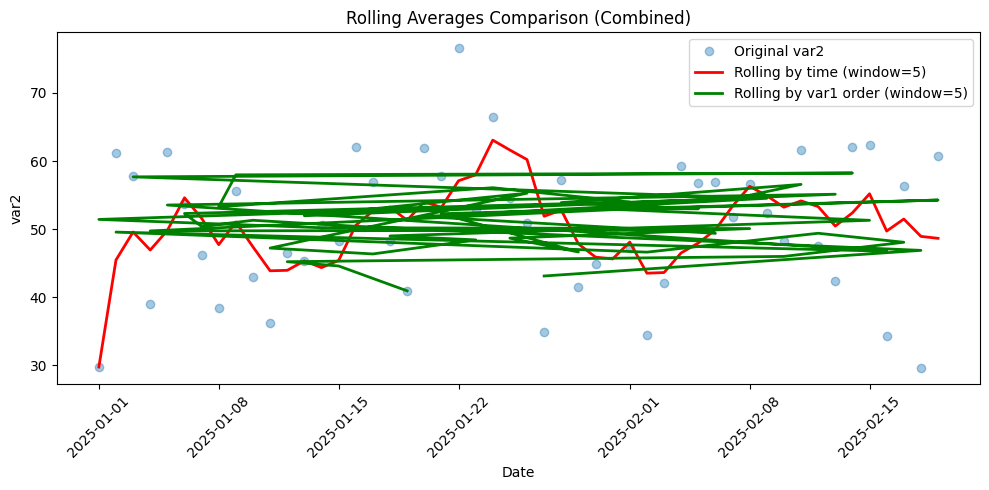

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Configurable variables
# -----------------------------
roll_var = 'var2'       # Variable to compute rolling average on
sort_var1 = 'date'      # First sort option (time-based)
sort_var2 = 'var1'      # Second sort option (value-based)
window_size = 5         # Rolling window size (number of observations)

# -----------------------------
# Create sample dataset
# -----------------------------
np.random.seed(42)
n = 50
dates = pd.date_range('2025-01-01', periods=n, freq='D')
var1 = np.random.randint(10, 100, size=n)
var2 = np.random.normal(loc=50, scale=10, size=n)

df = pd.DataFrame({'date': dates, 'var1': var1, 'var2': var2})

# -----------------------------
# Rolling averages
# -----------------------------
df_time = df.sort_values(sort_var1).copy()
df_time[f'{roll_var}_rolling_time'] = df_time[roll_var].rolling(window=window_size, min_periods=1).mean()

df_var1 = df.sort_values(sort_var2).copy()
df_var1[f'{roll_var}_rolling_var1'] = df_var1[roll_var].rolling(window=window_size, min_periods=1).mean()

# -----------------------------
# Side-by-side visualization
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].plot(df_time['date'], df_time[roll_var], 'o', alpha=0.6, label=f'Original {roll_var}')
axes[0].plot(df_time['date'], df_time[f'{roll_var}_rolling_time'], color='red', linewidth=2, label=f'Rolling by time (window={window_size})')
axes[0].set_title('Rolling Average by Time Order')
axes[0].set_xlabel('Date')
axes[0].set_ylabel(roll_var)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(df_var1['date'], df_var1[roll_var], 'o', alpha=0.6, label=f'Original {roll_var}')
axes[1].plot(df_var1['date'], df_var1[f'{roll_var}_rolling_var1'], color='green', linewidth=2, label=f'Rolling by {sort_var2} order (window={window_size})')
axes[1].set_title(f'Rolling Average by {sort_var2} Order')
axes[1].set_xlabel('Date')
axes[1].set_ylabel(roll_var)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# -----------------------------
# Combined visualization
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(df_time['date'], df_time[roll_var], 'o', alpha=0.4, label=f'Original {roll_var}')
plt.plot(df_time['date'], df_time[f'{roll_var}_rolling_time'], color='red', linewidth=2, label=f'Rolling by time (window={window_size})')
plt.plot(df_var1['date'], df_var1[f'{roll_var}_rolling_var1'], color='green', linewidth=2, label=f'Rolling by {sort_var2} order (window={window_size})')
plt.title('Rolling Averages Comparison (Combined)')
plt.xlabel('Date')
plt.ylabel(roll_var)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# Explanation:
# -----------------------------
# - Rolling by time shows trends of the selected variable over chronological order.
# - Rolling by sort_var2 shows trends when ordering by another variable (magnitude-based).
# - Side-by-side plots and combined plot let you compare these smoothing methods.
# - Changing roll_var, sort_var1, sort_var2, or window_size at the top updates all plots immediately.